In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.neighbors import kneighbors_graph
import pandas as pd
import torch

In [3]:
np.set_printoptions(precision=4)
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
color_map =  plt.get_cmap('jet')

In [4]:
data=pd.read_csv("dataset_ejemplo_40_3_16.csv",sep=";")
data["S"]=pd.Categorical(data["estado"]).codes
dict(zip( data['S'], data['estado'] ))

{1: 'R', 0: 'A'}

In [5]:
X=data[["e1","e4","e10"]]
Y=data[["S"]].to_numpy().ravel()

In [6]:
X

,e1,e4,e10
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,1,1
9,0,0,0


In [7]:
#creamos una matriz de adyacencia usando K-Nearest Neighbors
A = kneighbors_graph(X, metric="hamming", n_neighbors=5).toarray()

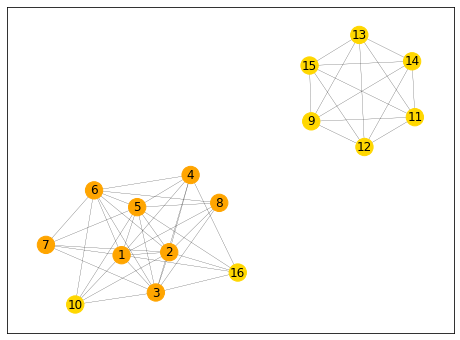

In [8]:
plt.figure(figsize=(8,6)) 
colores = [ "gold" if clase==0 else "orange" for clase in Y]
G=nx.from_numpy_matrix(A, create_using=nx.Graph())
for id,node in G.nodes(data=True):
    node["name"]=id+1
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw_networkx_nodes(G, node_color=colores,pos=pos)
labels = nx.get_node_attributes(G, 'name') 
nx.draw_networkx_labels(G,labels=labels,pos=pos);
nx.draw_networkx_edges(G,pos=pos,width=0.2,edge_color="black");

In [9]:
grafo=[]
for nodes in nx.connected_components(G):
    print(nodes)
    grafo.append(G.subgraph(nodes).copy())
len(grafo)

{0, 1, 2, 3, 4, 5, 6, 7, 9, 15}
{8, 10, 11, 12, 13, 14}


2

In [10]:
nx.laplacian_matrix(grafo[0]).todense();

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [11]:
nx.fiedler_vector(grafo[0])

array([-0.0000, -0.0000, -0.0000,  0.3759, -0.0000, -0.1620, -0.3151,
       -0.3151, -0.3151,  0.7312])

In [12]:
nx.algebraic_connectivity(grafo[0])

4.485863070664735

In [13]:
A=nx.to_numpy_matrix(grafo[0])
D = np.diag(A.sum(axis=1).flatten().tolist()[0])
L = D-A
print(pd.DataFrame(L))

     0    1    2    3    4    5    6    7    8    9
0  9.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
1 -1.0  9.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
2 -1.0 -1.0  9.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
3 -1.0 -1.0 -1.0  6.0 -1.0 -1.0  0.0  0.0  0.0 -1.0
4 -1.0 -1.0 -1.0 -1.0  9.0 -1.0 -1.0 -1.0 -1.0 -1.0
5 -1.0 -1.0 -1.0 -1.0 -1.0  8.0 -1.0 -1.0 -1.0  0.0
6 -1.0 -1.0 -1.0  0.0 -1.0 -1.0  5.0  0.0  0.0  0.0
7 -1.0 -1.0 -1.0  0.0 -1.0 -1.0  0.0  5.0  0.0  0.0
8 -1.0 -1.0 -1.0  0.0 -1.0 -1.0  0.0  0.0  5.0  0.0
9 -1.0 -1.0 -1.0 -1.0 -1.0  0.0  0.0  0.0  0.0  5.0


In [14]:
D=torch.from_numpy(D)
L=torch.from_numpy(L)
A=torch.from_numpy(A)

In [15]:
def distance_matrix(mat):
    d= ((mat.unsqueeze (0)-mat.unsqueeze (1))**2).sum (2)**0.5
    return d
d= distance_matrix(A);

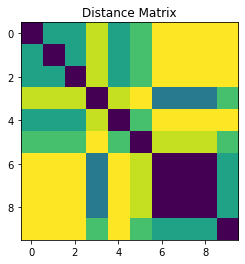

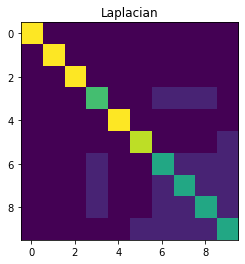

In [16]:
plt.figure()
plt.title("Distance Matrix")
plt.imshow(d.numpy())
plt.show(block=False)

plt.figure()
plt.title("Laplacian")
plt.imshow(L.numpy())
plt.show(block=False)

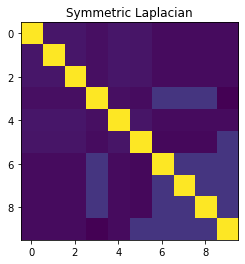

In [17]:
Lsym=torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D),-0.5)),L),torch.diag(torch.pow(torch.diag(D),-0.5)));
plt.figure()
plt.imshow(Lsym.numpy())
plt.title("Symmetric Laplacian")
plt.show(block=False)

[u,s,v]=torch.svd(Lsym)

tensor([ 0.0173,  0.0173,  0.0173,  0.4907,  0.0173, -0.3414, -0.2791, -0.2791,
        -0.2791,  0.6387], dtype=torch.float64)


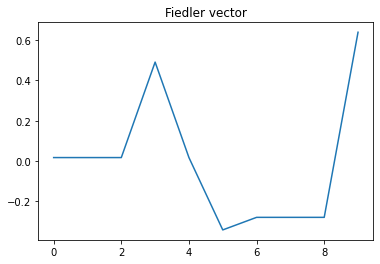

In [18]:
# plot fiedler vector
plt.figure()
plt.title('Fiedler vector')
print(u[:,-2])
plt.plot(u[:,-2].numpy());
plt.show(block=False)
norm  = colors.Normalize(vmin=-1, vmax=1)

scalarMap = cm.ScalarMappable( norm=norm , cmap=color_map)


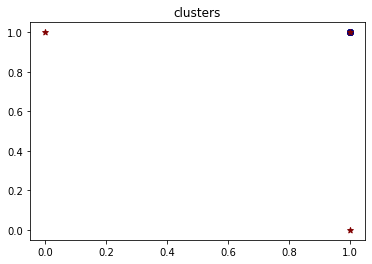

In [19]:
plt.figure()
plt.title('clusters')
for i in range(len(u[:,-2])):
	if u[i,-2]<0:
		color = scalarMap.to_rgba(-1)
		plt.scatter(A[i,0],A[i,1], color=color,marker='o')
	else:
		color = scalarMap.to_rgba(1)
		plt.scatter(A[i,0],A[i,1], color=color,marker='*')

plt.show(block=False)

[[ 0.0000]
 [-0.0000]
 [-0.0000]
 [-0.3759]
 [ 0.0000]
 [ 0.1620]
 [ 0.3151]
 [ 0.3151]
 [ 0.3151]
 [-0.7312]]


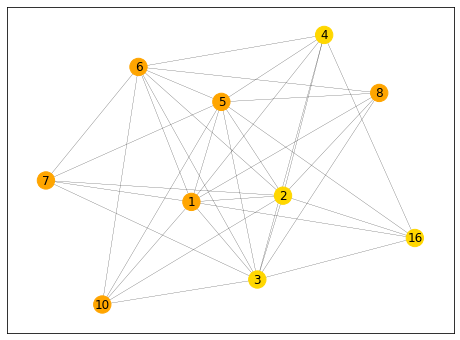

In [20]:
plt.figure(figsize=(8,6)) 
G=grafo[0]

A=nx.to_numpy_matrix(G)
D = np.diag(A.sum(axis=1).flatten().tolist()[0])
L = D-A
valores, vectores = np.linalg.eig(L)
orden=np.argsort(valores)
valores=valores[orden]
vectores=vectores[:,orden]
print(vectores[:,1])
clusters = vectores[:,1] < 0

colors = [ "gold" if valor else "orange" for valor in clusters]
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw_networkx_nodes(G, node_color=colors,pos=pos)
labels = nx.get_node_attributes(G, 'name') 
nx.draw_networkx_labels(G,labels=labels,pos=pos);
nx.draw_networkx_edges(G,pos=pos,width=0.2,edge_color="black");

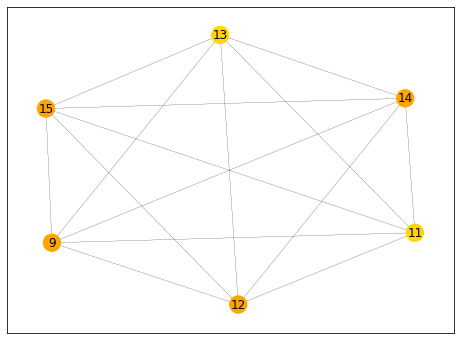

In [21]:
plt.figure(figsize=(8,6)) 
G=grafo[1]

A=nx.to_numpy_matrix(G)
D = np.diag(A.sum(axis=1).flatten().tolist()[0])
L = D-A
valores, vectores = np.linalg.eig(L)
orden=np.argsort(valores)
valores=valores[orden]
vectores=vectores[:,orden]
clusters = vectores[:,1] < 0

colors = [ "gold" if valor else "orange" for valor in clusters]
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw_networkx_nodes(G, node_color=colors,pos=pos)
labels = nx.get_node_attributes(G, 'name') 
nx.draw_networkx_labels(G,labels=labels,pos=pos);
nx.draw_networkx_edges(G,pos=pos,width=0.2,edge_color="black");

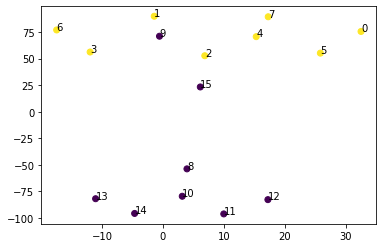

In [22]:
from sklearn.manifold import TSNE
manifold = TSNE(n_components=2, metric="hamming",learning_rate='auto',init='random', perplexity=3)
X_embedded=manifold.fit_transform(X)
x,y=X_embedded.T
fig, ax = plt.subplots()
ax.scatter(x, y, c=Y)

for i, value in enumerate(Y):
    ax.annotate(i, (x[i], y[i]))